In [1]:
!python -V

Python 3.12.3


In [28]:
import os
os.environ["ARROW_FLAG_DISABLE_LEGACY_EXTENSION_TYPE"] = "1"

In [29]:
import pandas as pd

In [30]:
import pickle

In [32]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 2.1 MB/s eta 0:00:00 0:00:01


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [17]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 3.1 MB/s eta 0:00:0000:0100:01


In [18]:
!pip install fastparquet

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 962.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 1.3 MB/s eta 0:00:00a 0:00:01


In [24]:
!pip install --upgrade pandas pyarrow

In [35]:
import os
print(os.getcwd())  # Confirm current working directory
print(os.path.isfile('yellow_tripdata_2023-01.parquet'))  # Confirm file existence

/mnt/c/Users/shubham_yadav/Documents/COXA-ENIT/lab/venv/MLOps Zoompcamp
True


In [36]:
!export ARROW_FLAG_DISABLE_LEGACY_EXTENSION_TYPE=1

In [55]:
df = pd.read_parquet('yellow_tripdata_2023-01.parquet',engine='fastparquet')
print(df.columns.tolist())
print(f"Number of columns: {df.shape[1]}")

df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
# df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
filtered_df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

fraction_left = len(filtered_df) / len(df)
print(f"Fraction of records left after removing outliers: {fraction_left:.4f}")

std_duration = df['duration'].std()
print(f"Standard deviation of trip duration in January 2023: {std_duration:.2f} minutes")

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
print(df[categorical])

dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X = dv.fit_transform(dicts)
print(f"Feature matrix dimensionality: {X.shape}")

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
Number of columns: 19
Fraction of records left after removing outliers: 0.9812
Standard deviation of trip duration in January 2023: 42.59 minutes
        PULocationID DOLocationID
0                161          141
1                 43          237
2                 48          238
3                138            7
4                107           79
...              ...          ...
3066761          107           48
3066762          112           75
3066763          114          239
3066764          230           79
3066765          262          143

[3009173 rows x 2 columns]
Feature matrix dimensionality: (3009173, 515)


In [56]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658406261871906

/tmp/ipykernel_15586/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_15586/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


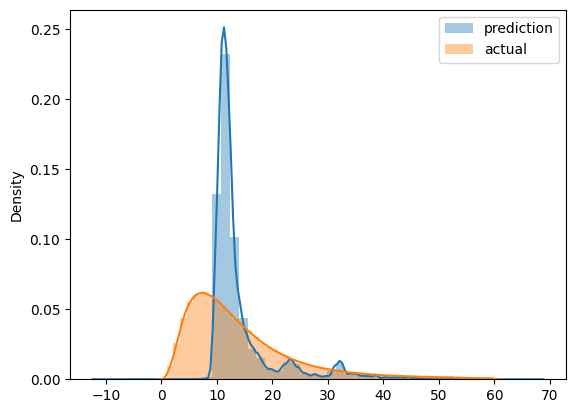

In [57]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [61]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename,engine='fastparquet')

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
        
    return df

In [62]:
df_train = read_dataframe('yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('yellow_tripdata_2023-02.parquet')

In [63]:
len(df_train), len(df_val)

(3009173, 2855951)

In [64]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [71]:
print(df_val)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0             1.0  2023-02-01 00:32:53   2023-02-01 00:34:34              2.0   
3             1.0  2023-02-01 00:29:33   2023-02-01 01:01:38              0.0   
4             2.0  2023-02-01 00:12:28   2023-02-01 00:25:46              1.0   
5             1.0  2023-02-01 00:52:40   2023-02-01 01:07:18              1.0   
6             1.0  2023-02-01 00:12:39   2023-02-01 00:40:36              1.0   
...           ...                  ...                   ...              ...   
2913950       2.0  2023-02-28 23:46:00   2023-03-01 00:05:00              NaN   
2913951       2.0  2023-02-28 23:26:02   2023-02-28 23:37:10              NaN   
2913952       2.0  2023-02-28 23:24:00   2023-02-28 23:38:00              NaN   
2913953       2.0  2023-02-28 23:03:00   2023-02-28 23:10:00              NaN   
2913954       2.0  2023-02-28 23:03:03   2023-02-28 23:12:51              NaN   

         trip_distance  Rat

In [72]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [73]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

14.513415443010443

In [76]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

10.450090571020159

In [77]:
lr = Ridge(alpha=0.00001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

15.492549038925333

In [79]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)